# Keypoint Localization with a Convolutional Neural Network using PyTorch

We will study localization problem with [Facial Keypoints Dataset](https://www.kaggle.com/c/facial-keypoints-detection/data) provided by [Kaggle](https://www.kaggle.com/). The aim of our task will be to locate distinguishing points on human faces.

### 1. Localization

Localization is one of the core tasks of Computer Vision. In this task, we aim to find the locations of objects in the given data. Then, we indicate their position in various representations based on our task. For instance, if we are looking for dogs in given images, we represent their location with bounding boxes. In our case, we will locate the keypoints of human faces, hence, we will have (x, y) coordinate representation as output vectors. An example of localization task can be seen in the following image:

![Localization example](./images/localization.png "Example Localization")

### 2. Facial Keypoints Dataset

Our dataset is provided by Kaggle. It consists of CSV files. Training data contains 7049 images. Each row of the CSV table contains (x, y) coordinates of 15 keypoints we want to detect per face, and input image as row-ordered list of pixels in the last column of each row. Examples of our dataset will be shown in upcoming code cells.

The following first three code cells can be used to download facial keypoints dataset we will use for this notebook using Kaggle API.

As we already stated, the following first three code cells can be used to download facial keypoints dataset we will use for this notebook using Kaggle API.

In [ ]:
#!kaggle competitions download -w -q facial-keypoints-detection
# Note that for this command to work you need kaggle package installed (pip install kaggle), Kaggle API installed on your PC (kaggle.json), 
# and you must accept competition rules for "Facial Keypoints Detection" competition.

In [ ]:
# if keypoint dataset is unzipped
#!unzip facial-keypoints-detection.zip
#!ls

In [ ]:
# if training is unzipped
#!unzip training.zip
#!ls

In [1]:
# Using better code for unzipping csv files:
import zipfile, os

def extract_files(fileName):
    """Parse and extract ZIP file in the given path.
    :param fileName: path to the ZIP file, including the extension.
    :return list of files within the archive.
    """
    print("Parsing {} ...".format(fileName))
    with zipfile.ZipFile(fileName, mode='r') as zipobj:
        fl = zipobj.namelist()
        print("List of files in {} is:".format(fileName))
        for f in fl: print(f)
        print("Extracting {} ...".format(fileName))
        zipobj.extractall()
    return fl

ftrn = extract_files("datasets/facial-keypoints-detection/training.zip")
ftst = extract_files("datasets/facial-keypoints-detection/test.zip")

Parsing datasets/facial-keypoints-detection/training.zip ...
List of files in datasets/facial-keypoints-detection/training.zip is:
training.csv
Extracting datasets/facial-keypoints-detection/training.zip ...
Parsing datasets/facial-keypoints-detection/test.zip ...
List of files in datasets/facial-keypoints-detection/test.zip is:
test.csv
Extracting datasets/facial-keypoints-detection/test.zip ...


If you are using `Google Colab`, you can use the following commented line to import drive into this notebook in runtime. For further information: [Google Colab](https://colab.research.google.com/?utm_source=scs-index#scrollTo=GJBs_flRovLc)

In [2]:
import pandas as pd
# from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

D:\Anaconda3\envs\myEnv001\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\envs\myEnv001\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda3\envs\myEnv001\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


If the following cell runs successfully, then, you are good to go.

In [3]:
print(torch.__version__)
print(pd.__version__)
print(np.__version__)

1.10.1+cu102
1.3.5
1.22.1


We explore our dataset further in the following cell. First, we load our dataset using `Pandas`. Then, we print the columns and the first 5 line of our dataset to check what our data looks like.

In the third print line, we check if there is any `null` values in our dataset which may hurt our training in later phases. As a data preprocessing step, we utilize pandas function `fillna` to change these `null` values into the last valid observation we made. It is similar to nearest neighbor interpolation. For further information: [fiilna](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html).

Then, we check if there is any `null` left.

In [4]:
data = pd.read_csv('training.csv')
print(data.columns)
print(data.head())
print(data.isnull().any().value_counts())
data.fillna(method = 'ffill',inplace = True)
print(data.isnull().any().value_counts())

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')
   left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274  

In addition to `null` values, we may have empty image pixels in the given dataset. We fill those values with `0`, so that, we can iterate over our dataset without any type error or empty pixel error.

In [5]:
num_train_data = len(data)
pixel_list = []
for i in range(num_train_data):
    row = data['Image'][i].split(' ')
    pixel = ['0' if x == '' else x for x in row] # handling empty image pixels
    pixel_list.append(pixel)

In `PyTorch`, the image data is represented by (B, C, W, H) where B = batch size, C = number of channels, W = width of the image, H = height of the image. In our case, the dataset is represented by (B, W, H, C). So, we need to swap the dimensions to properly process the data throughout our model.

In [6]:
# Pytorch takes channels in the second dimension. For that, I swap axes (dimensions)
image_tensor = np.array(pixel_list, dtype = 'float')
print(np.shape(image_tensor))
image_tensor = image_tensor.reshape(-1, 96, 96, 1)
print(np.shape(image_tensor))
image_tensor = np.swapaxes(image_tensor, 2, 3)
image_tensor = np.swapaxes(image_tensor, 1, 2)
print(np.shape(image_tensor))

(7049, 9216)
(7049, 96, 96, 1)
(7049, 1, 96, 96)


Here, we separate our input data into the training image and training ground-truth data. To do that, we remove the `Image` column from our dataset, then, the columns left are human face keypoint coordinates which are ground-truths.

In [7]:
labels = data.drop('Image',axis = 1)

label_list = []
for i in range(num_train_data):
    label = labels.iloc[i,:]
    label_list.append(label)
label_tensor = np.array(label_list,dtype = 'float')

We visualize some of them to understand what our task looks like. Also, to double-check if every processing we make so far is correct.

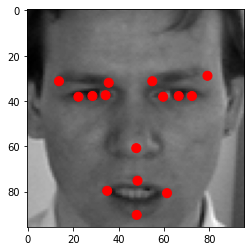

In [14]:
# This cell was problematic in my PC. So I ignored it.
from matplotlib.pyplot import Circle
index = random.randint(0,1000)
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(image_tensor[index].reshape(96,96),cmap='gray')
for xx, yy in label_tensor[index].reshape((15,2)):
    circ = Circle((xx,yy),2,color='red')
    ax.add_patch(circ)

Since we will not upload our model into the `Kaggle`, we separate some of our training images into the another set. Because we will use them as our test images. Then, we create our dataloaders for training and testing.

In [15]:
train_len = 6000
img_and_label = []
for i in range(train_len):
    img_and_label.append([image_tensor[i], label_tensor[i]])

# we use Dataloader objects in pytorch to easily iterate on our dataset while performing training loops
train_loader = torch.utils.data.DataLoader(img_and_label, shuffle=True, batch_size=500)
img1, lbl1 = next(iter(train_loader))
print("first training batch: \n" + "input shape: " + str(img1.shape) + "\n" + "label shape: " + str(lbl1.shape))

test_data = []
for i in range(train_len, num_train_data): # since we have no labels for real test data!
    test_data.append([image_tensor[i], label_tensor[i]])

test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=500)
test1, tlbl1 = next(iter(test_loader))
print("test batch: \n" + "input shape: " + str(test1.shape) + "\n" + "label shape: " + str(tlbl1.shape))

first training batch: 
input shape: torch.Size([500, 1, 96, 96])
label shape: torch.Size([500, 30])
test batch: 
input shape: torch.Size([500, 1, 96, 96])
label shape: torch.Size([500, 30])


Using PyTorch, we build our model in the following cell. Our model consists of 2D Convolution filters, Max pooling, Batch Normalization layers and Leaky ReLU as our activation function in the phase of feature extraction. Then, we utilize Linear layers, 1D Batch normalization, and Sigmoid activation function for further keypoint regression. Be careful that we do not use sigmoid layer in the final layer since we want to regress exact positions but not [0, 1] projected coordinates. Also, we flatten our mid-layer feature vector while we move forward from 2D feature extraction stage to 1D regression stage.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# we write our networks as class instances. dont forget to inherit from nn.Module
class Net(nn.Module):
    # we always need an init method to define our output matrices (similar to nodes in graph)
    def __init__(self):
        super(Net, self).__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.leaky_relu = nn.LeakyReLU(0.1)
        
        self.conv1 = nn.Conv2d(1, 32, 5) #1, 32
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 5) #32, 64
        self.conv2_bn = nn.BatchNorm2d(64)

        #self.conv3 = nn.Conv2d(16, 32, 5) #64, 128
        #self.conv3_bn = nn.BatchNorm2d(32)

        #self.conv4 = nn.Conv2d(32, 64, 5) #128, 256
        #self.conv4_bn = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 21 * 21, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 30)
        
    # we always need an forward method to draw our computational graph (similar to completing the graph with edges)
    def forward(self, x):

        x = self.max_pool(self.leaky_relu(self.conv1_bn(self.conv1(x))))
        x = self.max_pool(self.leaky_relu(self.conv2_bn(self.conv2(x))))
        #x = self.leaky_relu(self.conv3_bn(self.conv3(x)))
        #x = self.max_pool(self.leaky_relu(self.conv4_bn(self.conv4(x))))

        # vectorize (flatten)
        x = x.reshape(-1, 64 * 21 * 21)
        #x = torch.flatten(x)
        #x = torch.reshape(x, (input_shape, -1))
        x = torch.sigmoid(self.fc1_bn(self.fc1(x)))        
        x = torch.sigmoid(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return x

inzvaNet = Net()

We specify our loss function, optimizer, and the number of epochs we will train our model in the following cell.

In [17]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(inzvaNet.parameters(), lr=0.0001, momentum=0.9)
num_epoch = 10

In [18]:
inzvaNet = inzvaNet.float()

We switch from CPU to GPU if we have any available GPU devices. It will bring a huge increase in inference time for our model training. 

Note: Without GPU, it will take much time to train this model.

In [19]:
#we get info on our gpu, put it in the variable "device"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

#we carry our model into gpu
inzvaNet.to(device)

cuda:0


Net(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=28224, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)

Then, we will initiate our training loop. We iterate through our dataset and update our model. Also, we can observe the improvement of our model with a decrease in the loss values throughout the training.

In [20]:
# our training loop
# check for free memory option -> this code may lead to memory explosion if grads are not cleared, etc.
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0

    # here we use the dataloader object. it performs .next() operation in each iteration of the loop
    # we also group our batches with numbers. we do this with enumerate. we do this so we can know in which batch we are 
    for i, data in enumerate(train_loader, start = 0):
        # get the inputs; data is a list of [inputs, labels]

        #inputs, labels = data
        inputs, labels = data[0].float().to(device), data[1].float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = inzvaNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print('Epoch %d Loss: %.3f' %
                  (epoch + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Epoch 1 Loss: 1.342
Epoch 2 Loss: 1.319
Epoch 3 Loss: 1.278
Epoch 4 Loss: 1.235
Epoch 5 Loss: 1.191
Epoch 6 Loss: 1.141
Epoch 7 Loss: 1.102
Epoch 8 Loss: 1.054
Epoch 9 Loss: 1.008
Epoch 10 Loss: 0.961
Finished Training


We will test our trained model, so that, we can have a better understanding where our model fails and where our model performs better.

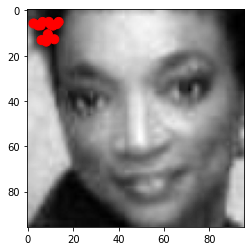

In [21]:
rand_test = random.randint(0,49)
test_batch = next(iter(test_loader))

test_batch_data = test_batch[0].float().to(device)
test_batch_label = test_batch[1].float().to(device)

preds = inzvaNet(test_batch_data).cpu()

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(test_batch_data[rand_test].cpu().view((96,96)), cmap = 'gray')

for xx, yy in preds[rand_test].reshape((15,2)):
    circ = Circle((xx, yy), 2, color='red')
    ax.add_patch(circ)

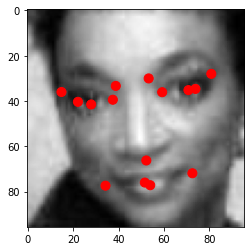

In [22]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(test_batch_data[rand_test].cpu().view((96,96)), cmap = 'gray')

for xx, yy in test_batch_label[rand_test].reshape((15,2)):
    circ = Circle((xx, yy), 2, color='red')
    ax.add_patch(circ)

In [23]:
# Remember to delete the extracted items from the local directory onced you are finished with them:
print("Deleting the extracted files...")
for f in ftrn: 
    try:
        os.remove(f)
    except:
        print("WARNING: File {} could not be deleted.".format(f))
for f in ftst: 
    try:
        os.remove(f)
    except:
        print("WARNING: File {} could not be deleted.".format(f))
print("Done.")

Deleting the extracted files...
Done.
